In [1]:
#!pip install cdlib
!pip uninstall cdlib

In [30]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special

import torch

np.seterr(all='raise')
scipy.special.seterr(all='raise')

#import cdlib

{'singular': 'raise',
 'underflow': 'raise',
 'overflow': 'raise',
 'slow': 'raise',
 'loss': 'raise',
 'no_result': 'raise',
 'domain': 'raise',
 'arg': 'raise',
 'other': 'raise'}

In [31]:
#from cdlib import algorithms
import networkx as nx

In [357]:
import pickle
adjacency_list = []
with open('adjacency_list.data', 'rb') as filehandle:
    adjacency_list = pickle.load(filehandle)

In [358]:
g = nx.Graph()
for i in range(len(adjacency_list)):
    g.add_node(i)
    

for a in range(len(adjacency_list)):
    for b in adjacency_list[a]:
        if g.has_edge(a,b):
            continue
        g.add_edge(a,b)

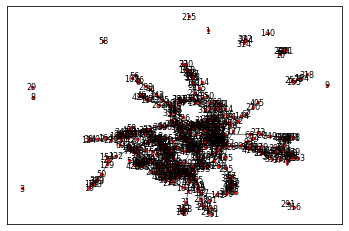

In [359]:
nx.draw_networkx(g, node_size = 5, node_color = 'r' , width = .5, font_size = 8, with_labels = True)


In [280]:
"""
Name :: UnityId
Shruti Kuber :: skuber
Abhishek Lingwal :: aslingwa
Raunaq Saxena :: rsaxena
Chen, Jie, and Yousef Saad.
"Dense subgraph extraction with application to algorithms detection."
IEEE Transactions on Knowledge and Data Engineering 24.7 (2012): 1216-1230.
Reference internal: https://github.com/imabhishekl/CSC591_Community_Detection
"""

class __Node:

    def __init__(self, name):
        self.name = name
        self.left = None
        self.right = None
        self.parent = None
        self.num_edges = 0
        self.vertices = set()
        self.density = 0


class __Tree:

    def __init__(self):
        self.root = None

    def findLCA_Node(self, src_node, dest_node):
        while src_node is not None:
            if dest_node.name in src_node.vertices:
                return src_node
            src_node = src_node.parent
        return None

    def count_vertices_and_edges(self, edges_list, nodes_list):
        for edge in edges_list:
            lca_node = None

            src_node = nodes_list[edge[0]] if nodes_list.__contains__(edge[0]) else None
            dst_node = nodes_list[edge[1]] if nodes_list.__contains__(edge[1]) else None
            if src_node is not None and dst_node is not None:
                lca_node = self.findLCA_Node(src_node, dst_node)

            if lca_node is not None:
                lca_node.num_edges = lca_node.num_edges + 1

    def count_vertices_and_edges_wrap(self, root):
        if root.left is not None and root.right is not None:
            self.count_vertices_and_edges_wrap(root.left)
            self.count_vertices_and_edges_wrap(root.right)
        if root.left is not None and root.right is not None:
            root.num_edges = root.left.num_edges + root.right.num_edges + root.num_edges
        # print root.name, root.num_edges

    def compute_density(self, root):
        if root.left is None and root.right is None:
            return
        total_vertices = float(len(root.vertices))
        max_vertices = total_vertices * (total_vertices - 1) / 2
        root.density = root.num_edges / max_vertices
        self.compute_density(root.left)
        self.compute_density(root.right)

    def extract_sub_graph(self, root, min_density, result):

        if root is None:
            return
        if root.density > min_density:
            com = []
            for elem in list(root.vertices):
                com.append(elem)
            result.append(com)
        else:
            self.extract_sub_graph(root.left, min_density, result)
            self.extract_sub_graph(root.right, min_density, result)


def __make_set(r):
    r.parent = None
    r.vertices.add(r.name)


def __set_find(r):
    while r.parent != None:
        r = r.parent
    return r


# Building a new Node as Union of two sets
def __set_union(x, y):
    r = __Node("P" + str(x.name) + str(y.name))
    r.left = x
    r.right = y
    x.parent = r
    y.parent = r
    r.vertices = r.vertices.union(x.vertices, y.vertices)
    return r

In [433]:
def GDMP2(graph, min_threshold=.75):

    scipy.special.seterr(all='raise')
    A = nx.adjacency_matrix(graph)
    adj_matrix = A.todense()

    M = np.zeros(adj_matrix.shape)

    row, col = adj_matrix.shape

    # Building similarity function matrix, ie, Cosine Function matrix of all Column Vectors

    for x in range(0, row):
        #if x == 25 or x == 26:
            #print(adj_matrix[:, x])
        for y in range(x, col):
            try:
                M[x][y] = (1 - scipy.spatial.distance.cosine(adj_matrix[:, x], adj_matrix[:, y]))
            except:
                print ("FAILED ON", x, y)
    
    ##------------------------------------------------------------------------------------------------------------------------------------
    #print(M*255)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
    img = Image.fromarray(M*255)
    ax1.imshow(img)
                
    tuples = []
    # On basis of zero graph
    min_value = 1 if min(graph.nodes()) > 0 else 0

    # Considering only non zero values
    for (x, y), value in np.ndenumerate(M):
        if value != 0 and x != y:
            tuples.append(((x + min_value, y + min_value), value))

    C = sorted(tuples, key=lambda x: x[1])
    t = np.count_nonzero(adj_matrix)
    C = C[-t:]
    ln = len(C)
    ln = ln - 1
    
    ##Visualize M-matrix step here
    ##------------------------------------------------------------------------------------------------------------------------------------
    #print(C[0])
    #print(C[0][0][0],C[0][0][1],C[0][1])
    c_array = np.empty([len(graph),len(graph)])
    for index in range(len(graph)):
        c_array[C[index][0][0]][C[index][0][1]] = float(C[index][1])
    img = Image.fromarray(c_array*255)
    ax2.imshow(img)

    nodes = dict()
    root_nodes = set()
    tree = __Tree()

    for index in range(ln, -1, -1):
        vertices, value = C[index]
        i, j = vertices
        if nodes.__contains__(i) is False:
            a = __Node(i)
            __make_set(a)
            nodes[i] = a
        if nodes.__contains__(j) is False:
            a = __Node(j)
            __make_set(a)
            nodes[j] = a

        i = nodes[i]
        j = nodes[j]
        ri = __set_find(i)
        rj = __set_find(j)
        if ri.vertices != rj.vertices:
            temp_root = __set_union(ri, rj)
            root_nodes.add(temp_root)

    root_nodes = filter(lambda entry: entry.parent is None, list(root_nodes))

    for temp_roots in root_nodes:
        tree.root = temp_roots

        # Counting number of vertices and Edges
        tree.count_vertices_and_edges(graph.edges(), nodes)

        # Summing up number of edges of children to parent
        tree.count_vertices_and_edges_wrap(tree.root)

        # Computing density of Tree Nodes
        tree.compute_density(tree.root)

        # Filtering Nodes as Per Density Threshold
        communities = []
        tree.extract_sub_graph(tree.root, min_threshold, communities)
        return communities

In [360]:
if nx.is_connected(g) != True:
    components_g = nx.connected_components(g)

gc = []
i = 0
min_nodes_requirement = 20

for component in components_g:
    temp_graph = nx.Graph()
    
    temp_graph.add_nodes_from(component)
    for a in range(len(adjacency_list)):
        for b in adjacency_list[a]:
            if temp_graph.has_edge(a,b):
                continue
            if temp_graph.has_node(a) and temp_graph.has_node(b):
                temp_graph.add_edge(a,b)
    print(len(temp_graph))
    if len(temp_graph) < min_nodes_requirement:
        continue
    gc.append(temp_graph)
    #print(component)
    i += 1

423
1
1
1
1
5
1
1
5
1
1
3
2


423

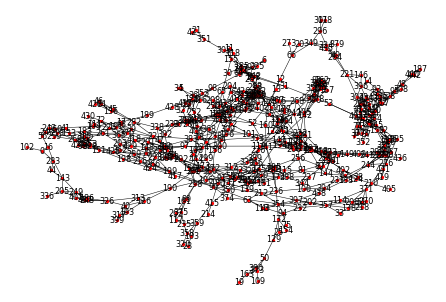

In [361]:
#nx.draw_networkx(gc[0] ,node_size = 5, node_color = 'r', width = .5, font_size = 8)
i = 0

nx.draw(gc[i], node_size = 5, node_color = 'r' , width = .5, font_size = 8, with_labels = True)

len(gc[i])

In [284]:
list(gc[0].nodes)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116]

/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


3

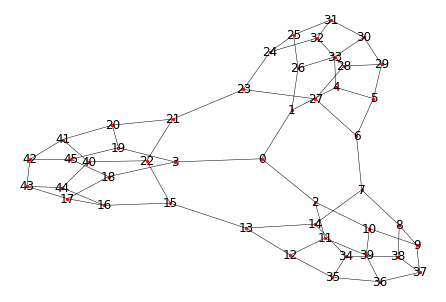

In [238]:
tutte=nx.tutte_graph()
tutteblock = GDMP2(tutte, min_threshold = 0.2)
nx.draw(tutte, node_size = 5, node_color = 'r', width = .5, font_size = 12, with_labels = True)
len(tutteblock)

/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


2

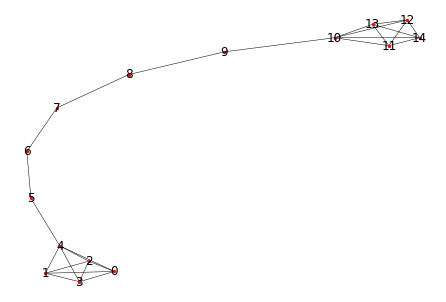

In [246]:
barbell=nx.barbell_graph(5,5)
barbellblock = GDMP2(barbell, min_threshold = 0.5)
nx.draw(barbell, node_size = 5, node_color = 'r', width = .5, font_size = 12, with_labels = True)
len(barbellblock)

In [229]:
barbellblock

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]

((143, 226), 0.20412414523193156)
143 226 0.20412414523193156
8


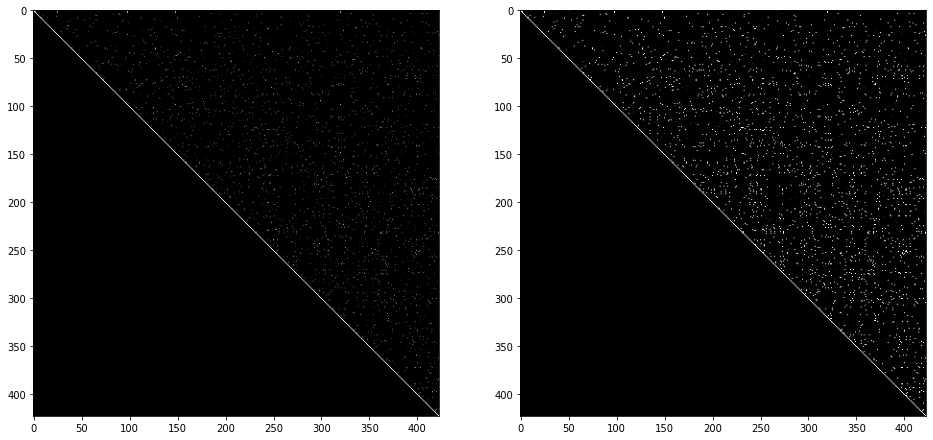

In [434]:
blocked = GDMP2(gc[0], min_threshold = .011)
print(len(blocked))

0
1
2
3
4
5
6
7


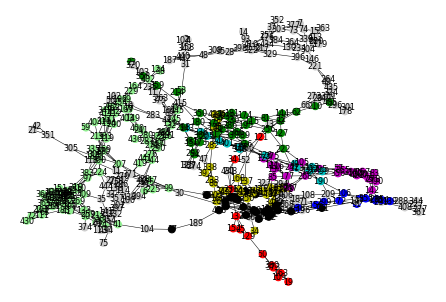

In [397]:
#print(len(blocked))
#mins = [min(short) for short in blocked]
#mins
#colormap = ['g' if index in mins else 'r' for index in gc[0]]
#sizemap = [100 if index in mins else 5 for index in gc[0]]

cdict = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'lightgreen'}
colormap = ['.8' for index in gc[0]]

for j in range(len(blocked)):
    print(j)
    for index in range(len(gc[0])):
        if index in blocked[j]:
            colormap[index] = cdict[j]
    
    #colormap = [cdict[j] if index in blocked[j] for index in gc[0]]
    pos = nx.spring_layout(gc[0], scale=10)
nx.draw(gc[0], pos, node_size = 50, node_color = colormap , width = .5, font_size = 8, with_labels = True)


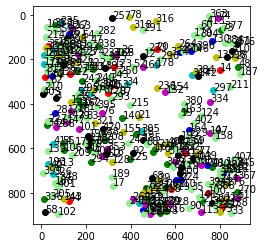

In [391]:
centroid_list = []
with open('centroid_list.data', 'rb') as filehandle:
    centroid_list = pickle.load(filehandle)

    
cluster_indices =  blocked
#print(cluster_indices)

scatter_x = [[centroid_list[index][0] for index in shortlist] for shortlist in cluster_indices]
scatter_y = [[centroid_list[index][1] for index in shortlist] for shortlist in cluster_indices]

#print(scatter_x,scatter_y)

group = np.array([])
for i in range(len(cluster_indices)):
    a = np.full((len(cluster_indices[i])),i)
    group = np.append(group,a,0)
group = group.flatten()
group = group.astype(int)

cdict = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'lightgreen'}


fig, ax = plt.subplots()
for i in range(len(scatter_x)):
    #print((max(ix)-min(ix)))
    ax.scatter(scatter_x[i], scatter_y[i], c = cdict[i])
    for j, txt in enumerate(cluster_indices[i]):
        ax.annotate(txt, (scatter_x[i][j], scatter_y[i][j]))

plt.axis('scaled')
plt.gca().invert_yaxis()
#plt.show()
#plt.savefig('clustersout.png', bbox_inches='tight')



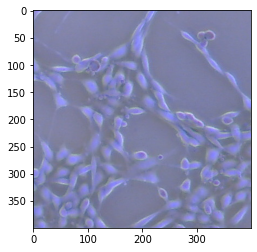

In [345]:
from PIL import Image

image_path = 'cl5-1111-tiny.JPG'
img = np.array(Image.open(image_path))
fig = plt.subplots()
plt.imshow(img)
#plt.savefig('out.png', bbox_inches='tight')

Text(0, 0.5, 'count')

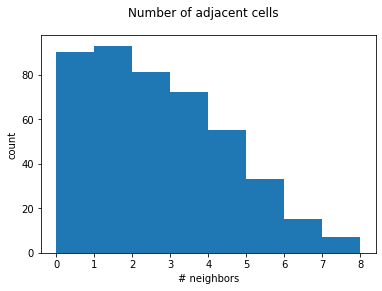

In [128]:
numbers_adjacencies = [len(sublist) for sublist in adjacency_list]

fig = plt.figure()
plt.hist(numbers_adjacencies, 8)
fig.suptitle('Number of adjacent cells')
plt.xlabel('# neighbors')
plt.ylabel('count')



In [183]:
with open('cluster_indices.data', 'wb') as filehandle:
    pickle.dump(blocked, filehandle)

In [231]:
barbellblock

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]